In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as disp

import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, DataLoader

from data import TrainTestSplitter, CurveTasks

In [2]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.L1 = nn.Linear(1, 10)
        self.L2 = nn.Linear(10, 10)
        self.L3 = nn.Linear(10, 1)
    
    def forward(self, x):
        h1 = nn.Sigmoid()(self.L1(x))
        h2 = nn.Sigmoid()(self.L2(h1))
        out = self.L3(h2)
        return out

In [3]:
def compute_mse(y, y_pred):
    return (y_pred - y)**2

In [4]:
# Data.
tts = TrainTestSplitter(test_frac=0.4)
meta_train = CurveTasks(train_test_splitter=tts, meta_train=True)
meta_test = CurveTasks(train_test_splitter=tts, meta_train=False)
dl_train = DataLoader(meta_train, sampler=RandomSampler(meta_train, replacement=False))
dl_test = DataLoader(meta_test, sampler=RandomSampler(meta_test, replacement=False))

torch.manual_seed(5)  # Set seed for stlitting.
for ((x_train, y_train), (x_test, y_test)) in dl_train:
    break  # Just take the first meta dataset.

In [5]:
def show_plot(x, y, y_preds, x_test, y_test, y_preds_test, ylim=None):
    
    x_ = x.numpy()
    y_ = y.numpy()
    y_preds_ = y_preds.numpy()
    x_test_ = x_test.numpy()
    y_test_ = y_test.numpy()
    y_preds_test_ = y_preds_test.numpy()
    
    # print(x_.shape, y_.shape, y_preds_.shape)
    
    plt.figure()
    plt.scatter(x_, y_, color="red", label="train target")
    plt.scatter(x_, y_preds_, color="blue", label="train prediction")
    plt.scatter(x_test_, y_test_, color="pink", label="test target")
    plt.scatter(x_test_, y_preds_test_, color="lightblue", label="test prediction")
    plt.ylim(ylim)
    plt.legend()
    plt.title("Prediction")
    
    f = plt.gcf()
    plt.close()
    
    return f

def plot_losses(train_loss, test_loss, xlim=None):
    
    plt.figure()
    plt.plot(train_loss, label="training loss")
    plt.plot(test_loss, label="test loss")
    plt.xlim(xlim)
    plt.legend()
    plt.title("Losses")
    
    f = plt.gcf()
    plt.close()
    
    return f

------------------------------
epoch 100:
------------------------------



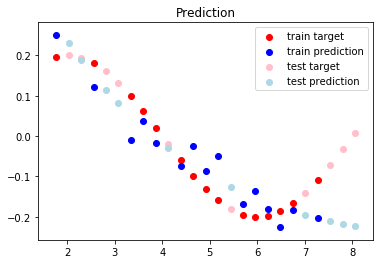

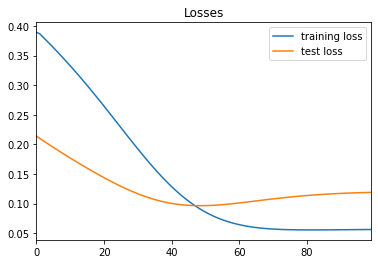


Training loss: 0.05625563859939575
Test loss: 0.11893989890813828


In [6]:
# Optimise.

torch.manual_seed(9)  # Set seed for optimisation.
model = Model()

epochs = 100
lr = 0.1

x = x_train[0]
y = y_train[0]

x_test_ = x_test[0]
y_test_ = y_test[0]

opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.2)

epoch_losses_train = np.zeros((epochs,))
epoch_losses_test = np.zeros((epochs,))

for epoch in range(epochs):
    
    disp.clear_output(wait=True)
    print("------------------------------\nepoch {}:\n------------------------------\n".format(epoch + 1))
    
    #######
    # Train
    #######
    
    model.train()  # Trian mode.
    
    y_preds = torch.zeros(len(x), requires_grad=False)
    mse_losses = torch.zeros(len(x), requires_grad=False)
    
    for it in range(len(x)):
        # Zero the gradients.
        model.zero_grad()

        # Compute loss.
        x_it = x[it].float().unsqueeze(0)
        y_pred = model(x_it)
        y_preds[it] = y_pred.detach()

        mse_loss = compute_mse(y_pred.squeeze(), y[it])
        mse_losses[it] = mse_loss
    
        # Backprop.
        mse_loss.backward(torch.tensor(1.))

        # Gradient descent.
        opt.step()
    
    ##########
    # Evaluate
    ##########
    
    model.eval()  # Evaluation mode.
    
    # Test loss:
    y_preds_test = torch.zeros(len(x_test_), requires_grad=False)
    mse_losses_test = torch.zeros(len(x_test_), requires_grad=False)
    for it in range(len(x_test_)):
        # Compute loss.
        x_it_test = x_test_[it].float().unsqueeze(0)
        y_pred_test = model(x_it_test)
        y_preds_test[it] = y_pred_test.detach()
        mse_loss_test = compute_mse(y_pred_test.squeeze(), y_test_[it])
        mse_losses_test[it] = mse_loss_test
    
    f1 = show_plot(x, y, y_preds, x_test_, y_test_, y_preds_test, ylim=None)
    
    epoch_mse_train = mse_losses.sum().item()
    epoch_mse_test = mse_losses_test.sum().item()
    
    epoch_losses_train[epoch] = epoch_mse_train
    epoch_losses_test[epoch] = epoch_mse_test
    f2 = plot_losses(epoch_losses_train[:epoch+1], epoch_losses_test[:epoch+1], xlim=(0, epochs-1))
    
    #########
    # Display
    #########
    
    disp.display(f1)
    disp.display(f2)
    print()
    print("Training loss: {}".format(epoch_mse_train))
    print("Test loss: {}".format(epoch_mse_test))
